In [1]:
import pickle
from pathlib import Path
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

In [2]:
def preprocess(X: pd.DataFrame, cloud_dataset=False):
    """
    The function will preprocess the data:
    1. Categorical features will be label encoded (Boy->1, Girl ->2)
    2. Numerical features will be scaled if the data is intended to be used for baseline. For cloud data set, no scaling will be preformed.

    Return pd.Dataframe
    """
    # Identify categorical and numeric columns
    categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
    numeric_cols = X.select_dtypes(include=['number']).columns.tolist()

    # Initialize lists to store processed columns
    processed_columns = []

    # If there are categorical columns, apply one-hot encoding
    if categorical_cols:
        print("\nEncoding categorical columns...")
        X_categorical = pd.get_dummies(X[categorical_cols], drop_first=True)
        # label_encoder = LabelEncoder()
        # X_categorical = pd.DataFrame()
        # for col in categorical_cols:
        #     # X_categorical[col] = label_encoder.fit_transform(X[col])
        processed_columns.append(X_categorical)

    # Apply standard scaling to the numeric columns
    if numeric_cols:
        print("\nScaling numerical columns...")
        scaler = MinMaxScaler()
        # X_numeric = X[numeric_cols]
        # if cloud_dataset:
        X_numeric = pd.DataFrame(scaler.fit_transform(X[numeric_cols]), columns=numeric_cols, index=X.index)
        # else:
        #     X_numeric = pd.DataFrame(scaler.fit_transform(X[numeric_cols]), columns=numeric_cols, index=X.index)

        processed_columns.append(X_numeric)

    # Combine the processed columns
    if processed_columns:
        X_processed = pd.concat(processed_columns, axis=1)
    else:
        X_processed = X.copy()  # If there are no categorical or numeric columns, keep the original dataframe


    return X_processed

In [4]:
class RawDataset:
    name: str

    def __init__(self, **kwargs):

        self.X, self.y = None, None
        self.sample_split = 1
        self.baseline_model = "neural_network"
        self.name = None
        self.metadata = {}

    def get_n_classes(self):
        return len(np.unique(self.y))

    def get_number_of_features(self):
        return self.X.shape[1]

    def get_dataset(self):
        return self.X, self.y


    def _get_model(self, X_train, y_train):
        inputs = Input(shape=(X_train.shape[1],))  # Dynamic input shape

        # Define the hidden layers
        x = BatchNormalization()(inputs)
        x = Dense(units=128, activation='leaky_relu')(x)
        x = Dropout(0.3)(x)

        # x = Dense(units=64, activation='leaky_relu')(x)
        # x = Dropout(0.3)(x)

        # Define the output layer
        outputs = Dense(units=len(np.unique(y_train)), activation='softmax')(x)

        # Create the model
        clf = Model(inputs=inputs, outputs=outputs)

        # Compile the model with F1 Score
        clf.compile(optimizer='adam',
                      loss='categorical_crossentropy',
                      )

        return clf

In [5]:
from pmlb import fetch_data

class PMLBDataset(RawDataset):

    def __init__(self,  **kwargs):
        super().__init__(**kwargs)
        dataset_name = "ring"

        dataset = fetch_data(dataset_name)
        self.X, self.y = self._preprocess(dataset)
        self.cloud_models = kwargs.get("cloud_models")
        self.name = dataset_name
        self.metadata["labels"] = [0, 1]
        self.metadata['targe_column'] = "target"

    def _preprocess(self, dataset: pd.DataFrame):
        dataset = dataset.dropna().sample(frac=1, random_state=42).reset_index(drop=True)
        X,y = dataset.drop(columns=["target"]), dataset["target"]
        return preprocess(X, cloud_dataset=True), y

In [6]:
class HelocDataset(RawDataset):
    name = 'heloc'

    def __init__(self, **kwargs):

        super().__init__(**kwargs)
        DATASET_PATH = Path("..") / "data" / "heloc" / f"dataset.csv"
        dataset = pd.read_csv(DATASET_PATH)
        if "Unnamed: 0" in dataset.columns:
            dataset.drop(columns=["Unnamed: 0"], inplace=True)
        self.X, self.y = self._preprocess(dataset)
        self.cloud_models = kwargs.get("cloud_models")
        self.name = HelocDataset.name
        self.metadata["labels"] = ["Bad", "Good"]
        self.metadata['targe_column'] = "RiskPerformance"
        self.metadata['description'] = "The HELOC dataset from FICO. Each entry in the dataset is a line of credit, typically offered by a bank as a percentage of home equity (the difference between the current market value of a home and its purchase price). The task is a binary classification task."

    def _preprocess(self, dataset):
        X, y = dataset.iloc[:, 1:], dataset.iloc[:, 0]

        # Remove the bug in the dataset where the entire row has -9 values
        mask = ~(X == -9).all(axis=1)
        X = X[mask]
        y = y[mask]

        y = y.replace({"Bad": 0, "Good": 1}).astype(int)
        return preprocess(X, cloud_dataset=True), y

In [7]:
# dataset = HelocDataset()
dataset = PMLBDataset()


Scaling numerical columns...


In [8]:
dataset.X.shape

(7400, 20)

In [9]:
import pandas as pd

from keras.src.callbacks import EarlyStopping
from keras.src.layers import Dropout, Dense, BatchNormalization, Input, Flatten
import torch.nn as nn
import tensorflow as tf
import keras


class SparseAE(nn.Module):
    name: str = "sparse_ae"

    def __init__(self, **kwargs):
        super(SparseAE, self).__init__()
        X = kwargs.get("X")
        self.model = self._get_trained_model(X.astype(float))
        self.output_shape = (1, 64)

    def forward(self, x):

        if type(x) is pd.DataFrame:
            x = x.to_numpy()

        embedding = self.model(x)
        return embedding

    def _get_trained_model(self, X:np.ndarray | pd.DataFrame):

        def sparse_loss(y_true, y_pred):
            sparsity_level = 0.05
            lambda_sparse = 0.1
            mse_loss = tf.reduce_mean(keras.losses.MeanSquaredError()(y_true, y_pred))
            hidden_layer_output = encoder(y_true)
            mean_activation = tf.reduce_mean(hidden_layer_output, axis=0)

            kl_divergence = tf.reduce_sum(sparsity_level * tf.math.log(sparsity_level / (mean_activation + 1e-10)) +
                                          (1 - sparsity_level) * tf.math.log(
                (1 - sparsity_level) / (1 - mean_activation + 1e-10)))

            return mse_loss + lambda_sparse * kl_divergence

        input_dim = X.shape[1]
        encoding_dim = max(int(input_dim * 1.5), 64)
        inputs = Input(shape=(input_dim,))
        encoded = Dense(encoding_dim, activation="relu")(inputs)
        decoded = Dense(input_dim, activation='sigmoid')(encoded)

        autoencoder = keras.Model(inputs, decoded)
        encoder = keras.Model(inputs, encoded)
        early_stop = EarlyStopping(patience=2, monitor="loss")

        autoencoder.compile(optimizer='adam', loss=sparse_loss)
        autoencoder.fit(X, X, epochs=50, batch_size=256, shuffle=True, callbacks=[early_stop])

        return encoder

model = SparseAE(X=dataset.X)

/Users/eden.yavin/Projects/Tabular-Cloud-ML/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Epoch 1/50


2025-05-07 09:01:56.596521: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Pro
2025-05-07 09:01:56.596586: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 36.00 GB
2025-05-07 09:01:56.596593: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 13.50 GB
I0000 00:00:1746597716.596948 1401415 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1746597716.596999 1401415 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2025-05-07 09:01:56.935947: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: nan
Epoch 2/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: nan


In [10]:
import json

from sklearn.model_selection import train_test_split

class RawDataExperimentDatabase:
    """
    This will enable consistent experiments - Each split of dataset will be save, i.e. the indexes will be saved.
    Thus changes to the data will not result in changes to the split
    """
    def __init__(self, dataset: RawDataset):
        self.dataset = dataset
        db_path = os.path.join("..","data", dataset.name)
        os.makedirs(db_path, exist_ok=True)
        self.db_path = os.path.join(db_path, f"{dataset.name}_dataset.json")
        self.key = str(1)
        if os.path.exists(self.db_path):
            print(f"Path exists: {self.db_path}")
            self.db = json.load(open(self.db_path, "r"))
            self.empty = False if self.key in self.db else True
        else:
            self.db = {1: {}}
            self.empty = True


    def _save(self):
        with open(self.db_path, "w") as f:
            json.dump(self.db, f)

    def get_split(self):

        X, y = self.dataset.get_dataset()

        if self.empty:
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y,
                                                                random_state=42)


            X_sample, y_sample = X_train, y_train


            new_data = {}
            new_data["train_index"] = X_train.index.tolist()
            new_data["imm_train_index"] = X_sample.index.tolist()
            new_data["test_index"] = X_test.index.tolist()

            self.db[self.key] = new_data

            print(f"#### CREATED NEW INDEX FOR 1 - INDEX SIZE {len(X_sample)}")

            self._save()

        else:
            indexes = self.db[self.key]
            # Get the existing indices and create new dataframes
            X_train = pd.DataFrame(X.loc[indexes["train_index"]])
            y_train = pd.Series(y.loc[indexes["train_index"]])
            X_sample = pd.DataFrame(X.loc[indexes["imm_train_index"]])
            y_sample = pd.Series(y.loc[indexes["imm_train_index"]])
            X_test = pd.DataFrame(X.loc[indexes["test_index"]])
            y_test = pd.Series(y.loc[indexes["test_index"]])
            print(f"LOADED INDEX 1 - INDEX SIZE {len(X_sample)}")

        return X_train.values, X_test.values, X_sample.values, y_train.values, y_test.values, y_sample.values


In [11]:
X_train, X_test, X_sample, y_train, y_test, y_sample = RawDataExperimentDatabase(dataset).get_split()

Path exists: ../data/ring/ring_dataset.json
LOADED INDEX 1 - INDEX SIZE 6660


In [12]:
X_train_emb = model.forward(X_sample)
X_test_emb = model.forward(X_test)

In [15]:
from keras.src.metrics import F1Score
from keras.src.callbacks import LearningRateScheduler
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import accuracy_score, f1_score
from keras.src.models import Model

class NeuralNetworkInternalModel(BaseEstimator, ClassifierMixin):

    def __init__(self, **kwargs):
        self.batch_size = 64
        self.dropout_rate = 0.3
        self.epochs = 100
        self.model: Model = None

    def fit(self, X, y):
        lr_scheduler = LearningRateScheduler(lambda epoch: 0.0001 * (0.9 ** epoch))
        early_stopping = EarlyStopping(patience=2, monitor='loss')
        self.model.fit(X, y, epochs=self.epochs, batch_size=self.batch_size, callbacks=[lr_scheduler, early_stopping])

    def predict(self, X):
        prediction = self.model.predict(X)
        return np.argmax(prediction, axis=1)

    def predict_proba(self, X):
        return self.model.predict(X)

    def evaluate(self, X, y):
        if len(y.shape) == 2:
            y = np.argmax(y, axis=1)

        pred = self.predict(X)
        return accuracy_score(y, pred), f1_score(y, pred, average='weighted')




class EmbeddingBaseline(NeuralNetworkInternalModel):

    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.name = "neural_network"
        num_classes = kwargs.get("num_classes")
        input_shape = kwargs.get("input_shape")
        self.model = self.get_model(num_classes=num_classes, input_shape=input_shape)

    def get_model(self, num_classes, input_shape):

        if isinstance(input_shape, int):
            input_shape = (input_shape,)

        inputs = Input(shape=input_shape)  # Dynamic input shape

        # Define the hidden layers
        x = BatchNormalization()(inputs)
        x = Dense(units=1024, activation='leaky_relu')(x)
        x = Dropout(self.dropout_rate)(x)

        x = BatchNormalization()(x)
        x = Dense(units=512, activation='leaky_relu')(x)
        x = Dropout(self.dropout_rate)(x)

        x = BatchNormalization()(x)
        x = Dense(units=256, activation='leaky_relu')(x)
        x = Dropout(self.dropout_rate)(x)

        x = BatchNormalization()(x)
        x = Dense(units=128, activation='leaky_relu')(x)
        x = Dropout(self.dropout_rate)(x)

        # Define the output layer
        outputs = Dense(units=num_classes, activation='softmax')(x)

        # Create the model
        model = Model(inputs=inputs, outputs=outputs)

        # Compile the model with F1 Score
        model.compile(optimizer='adam',
                      loss='categorical_crossentropy',
                      metrics=['accuracy', F1Score()]
                      )

        return model



In [16]:
from tensorflow.keras.utils import to_categorical


baseline_model = EmbeddingBaseline(num_classes=2, input_shape=X_train_emb.shape[1])

# Convert integer labels to one-hot encoded labels
y_train_one_hot = to_categorical(y_train, num_classes=2)
y_test_one_hot = to_categorical(y_test, num_classes=2)

# Fit the model with one-hot encoded labels
baseline_model.fit(
    X_train_emb, y_train_one_hot  # Use one-hot encoded labels here
)


Epoch 1/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.6896 - f1_score: 0.6771 - loss: 0.6975 - learning_rate: 1.0000e-04
Epoch 2/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9196 - f1_score: 0.9194 - loss: 0.2246 - learning_rate: 9.0000e-05
Epoch 3/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.9212 - f1_score: 0.9211 - loss: 0.2025 - learning_rate: 8.1000e-05
Epoch 4/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.9323 - f1_score: 0.9322 - loss: 0.1718 - learning_rate: 7.2900e-05
Epoch 5/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9355 - f1_score: 0.9354 - loss: 0.1721 - learning_rate: 6.5610e-05
Epoch 6/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9319 - f1_score: 0.9319 - loss: 0.1720 - learning_rate: 5.9049e-05
Epoch 7/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.9355 - f1_score: 0.9355 - loss: 0.1658 - learning_rate: 5.3144e-05
Epoch 8/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step -

In [17]:
baseline_model.evaluate(
    X_test_emb, y_test,
)

24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step


(0.9662162162162162, 0.9661785866128181)

# Explore Triangulations


In [1]:
import matplotlib.pyplot as plt # For visualization
import pickle
from openTSNE import TSNE

def visualize(data, dataset_name, acc=None):
    triangulations = data.train.features[1, : 512 * 6].reshape(6, 512)


    tsne_model = TSNE(
        n_components=2,       # For 2D visualization
        perplexity=1.33,
        random_state=42,      # For reproducibility
        metric="euclidean",   # Default metric
        n_jobs=-1             # Use all available CPU cores
    )
    embedding = tsne_model.fit(triangulations)
    plt.figure(figsize=(10, 8))

    if embedding is not None:
        plt.scatter(embedding[:, 0], embedding[:, 1], s=100) # s is marker size
        # You can add labels if these 5 "samples" have distinct meanings
        for i in range(embedding.shape[0]):
            plt.text(embedding[i, 0] + 0.02, embedding[i, 1] + 0.02, f"Sample {i+1}", fontsize=9)
    title = f't-SNE visualization of 5 derived samples, Dataset {dataset_name}'
    if acc is not None:
        title += f', Original Accuracy On Data: {acc:.4f}'
    plt.title(title)
    plt.xlabel('t-SNE dimension 1')
    plt.ylabel('t-SNE dimension 2')
    plt.grid(True)
    plt.show()

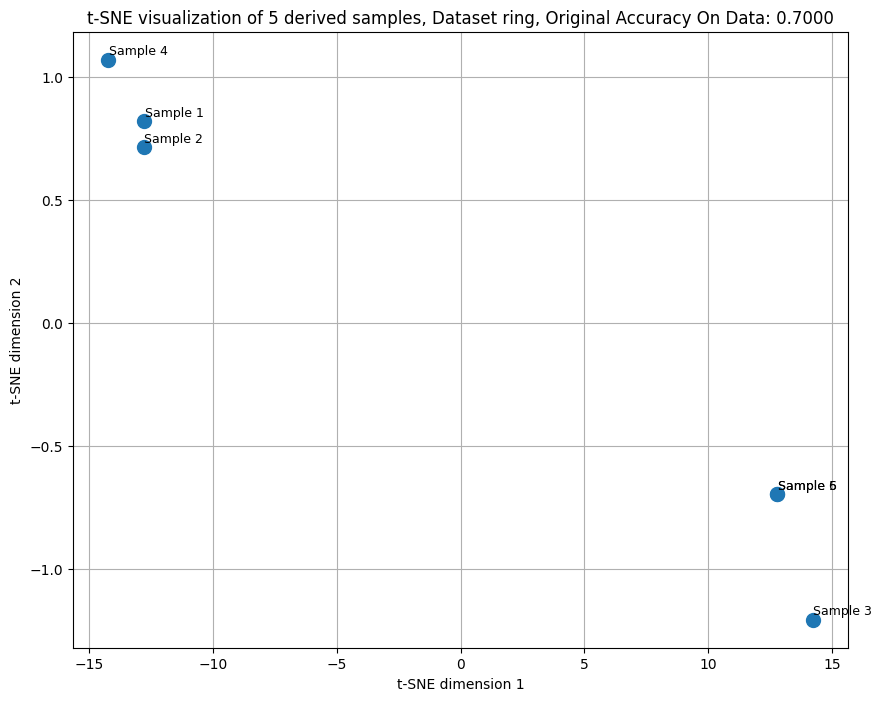

In [3]:


# First dataset Ring - It is a good result dataset with accuracy around 0.7
with open("/Users/eden.yavin/Projects/Tabular-Cloud-ML/output/ring/rotate/cloud/xception/1/dataset.pkl", "rb") as f:
    dataset = pickle.load(f)

visualize(dataset, 'ring', 0.7)

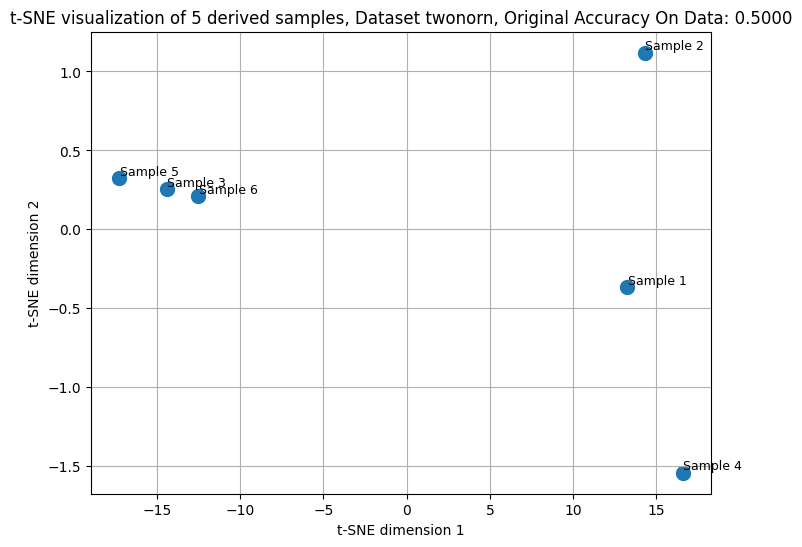

In [48]:
# First dataset Ring - It is a good result dataset with accuracy around 0.7
with open("/Users/eden.yavin/Projects/Tabular-Cloud-ML/output/twonorm/rotate/cloud/xception/1/dataset.pkl", "rb") as f:
    dataset = pickle.load(f)

visualize(dataset, 'twonorn', 0.5)

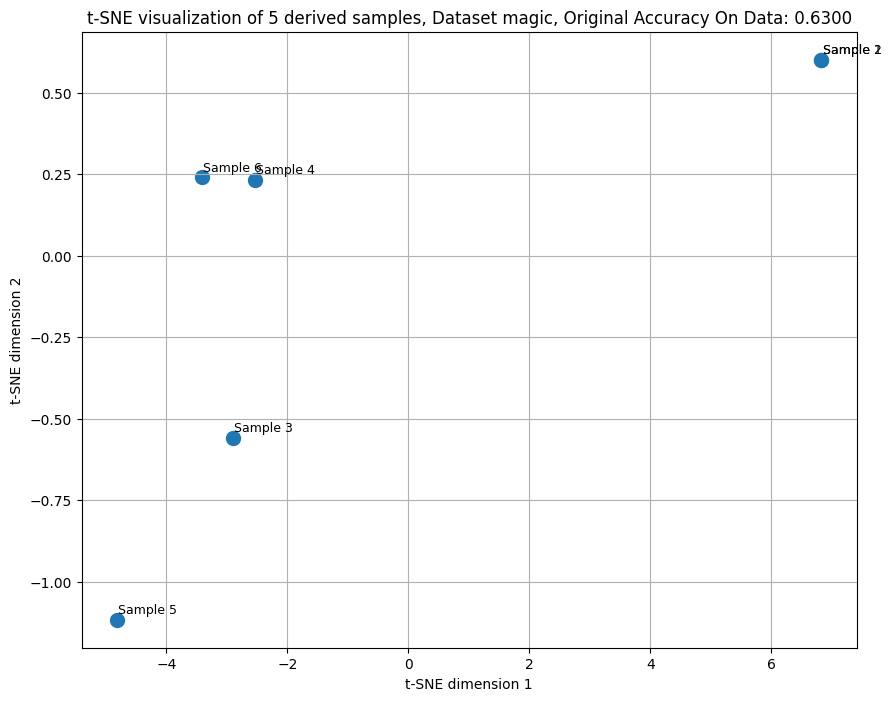

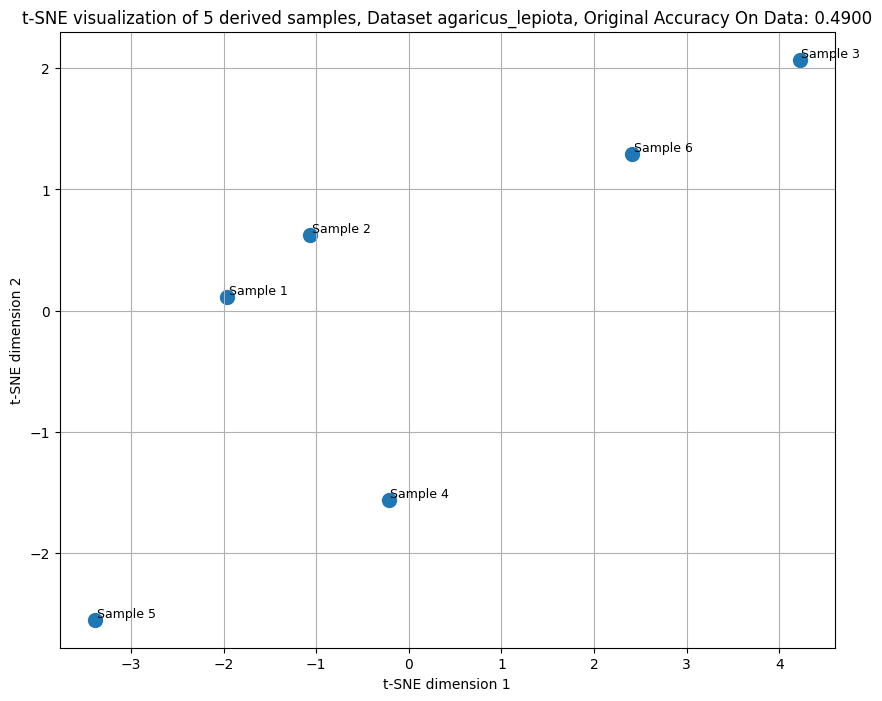

In [54]:

with open("/Users/eden.yavin/Projects/Tabular-Cloud-ML/output/agaricus_lepiota/rotate/cloud/xception/1/dataset.pkl", "rb") as f:
    dataset = pickle.load(f)

visualize(dataset, 'agaricus_lepiota', 0.49)

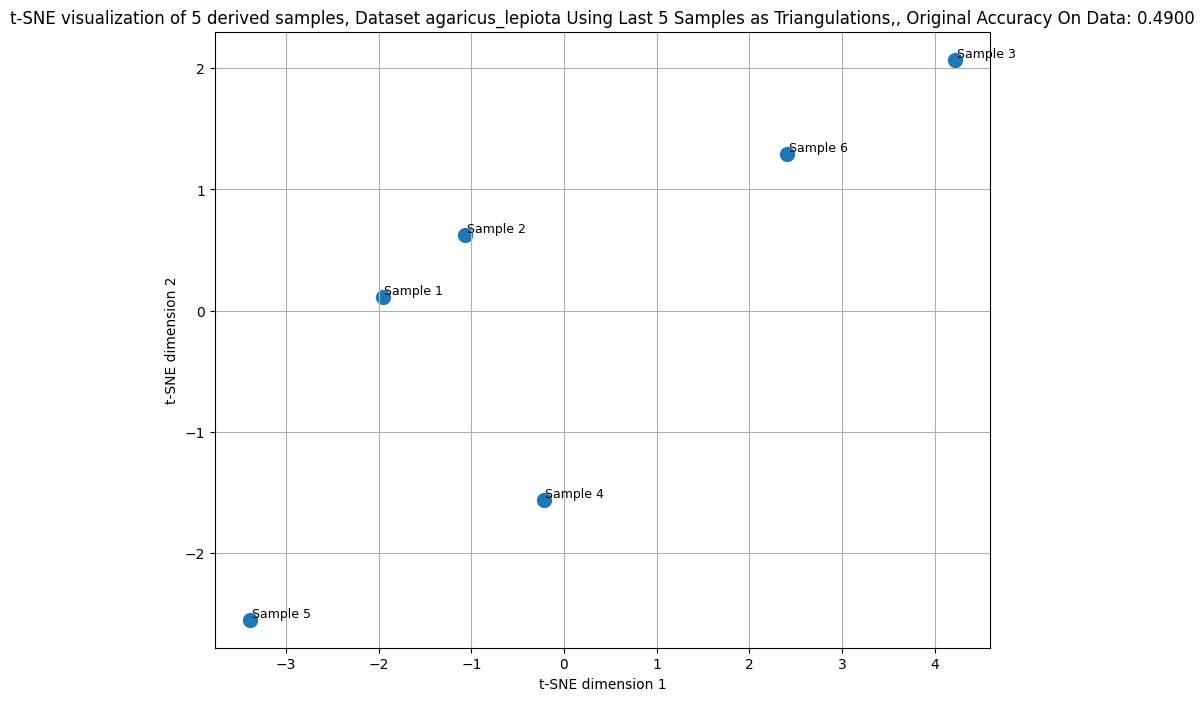

In [4]:
with open("/Users/eden.yavin/Projects/Tabular-Cloud-ML/output/agaricus_lepiota/rotate/cloud/xception/1/dataset.pkl", "rb") as f:
    dataset = pickle.load(f)

visualize(dataset, 'agaricus_lepiota Using Last 5 Samples as Triangulations,', 0.49)

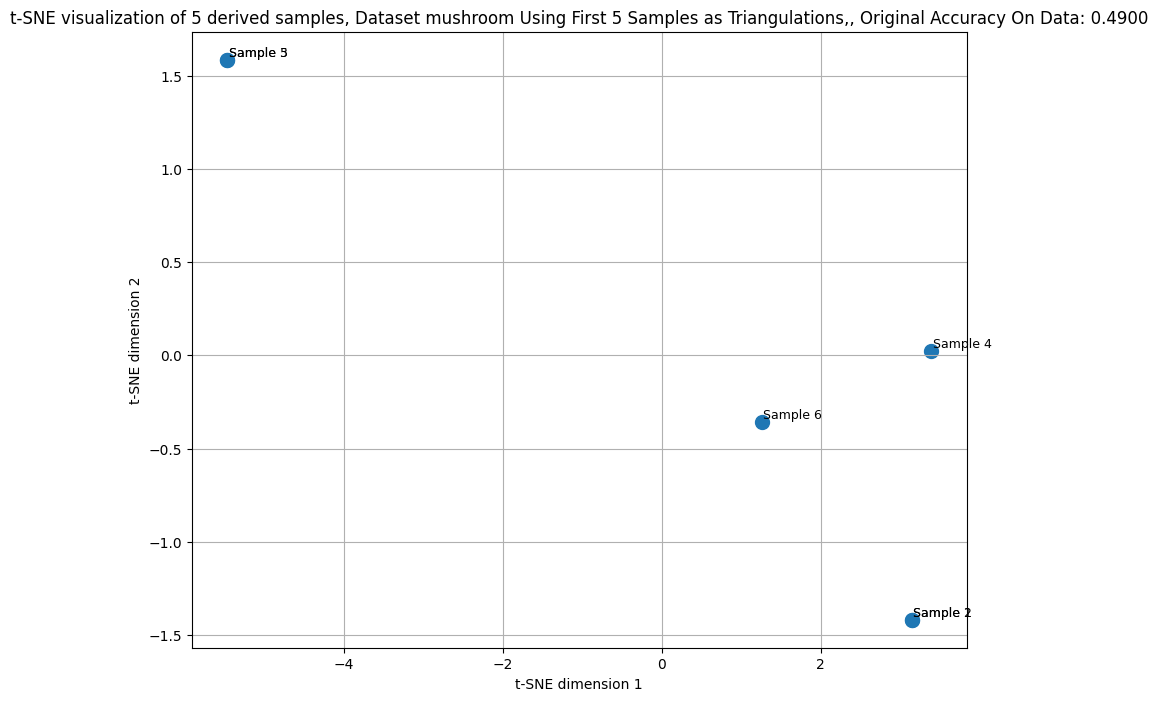

In [5]:
with open("/Users/eden.yavin/Projects/Tabular-Cloud-ML/output/mushroom/rotate/cloud/xception/2/dataset.pkl", "rb") as f:
    dataset = pickle.load(f)

visualize(dataset, 'mushroom Using First 5 Samples as Triangulations,', 0.49)

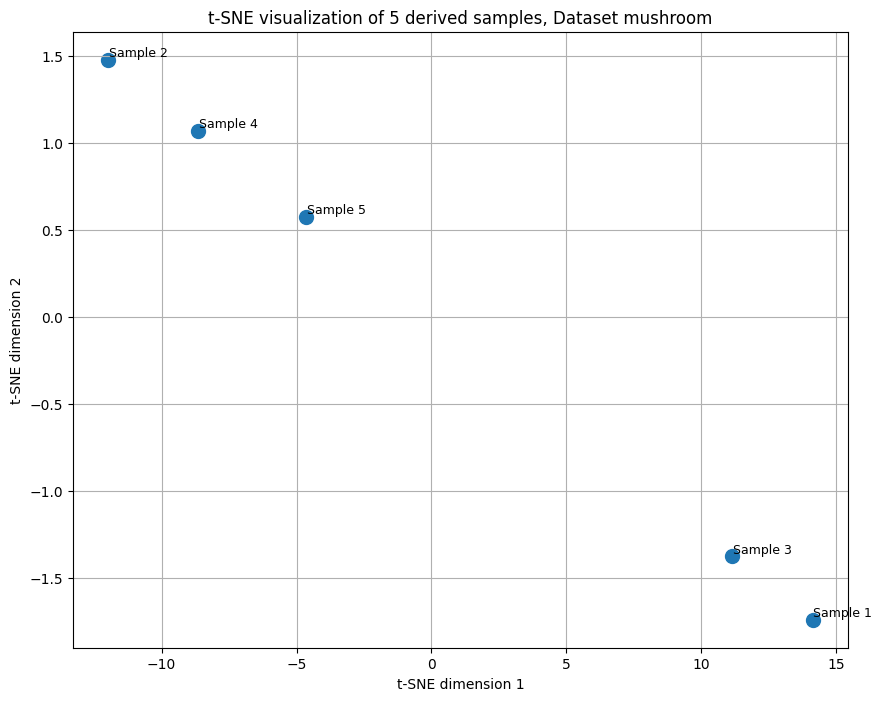

In [12]:
import numpy as np
first = np.load("first.npy")


tsne_model = TSNE(
    n_components=2,       # For 2D visualization
    perplexity=1.33,
    random_state=42,      # For reproducibility
    metric="euclidean",   # Default metric
    n_jobs=-1             # Use all available CPU cores
)
embedding = tsne_model.fit(first)
plt.figure(figsize=(10, 8))

if embedding is not None:
    plt.scatter(embedding[:, 0], embedding[:, 1], s=100) # s is marker size
    # You can add labels if these 5 "samples" have distinct meanings
    for i in range(embedding.shape[0]):
        plt.text(embedding[i, 0] + 0.02, embedding[i, 1] + 0.02, f"Sample {i+1}", fontsize=9)
title = f't-SNE visualization of 5 derived samples, Dataset mushroom'
plt.title(title)
plt.xlabel('t-SNE dimension 1')
plt.ylabel('t-SNE dimension 2')
plt.grid(True)
plt.show()

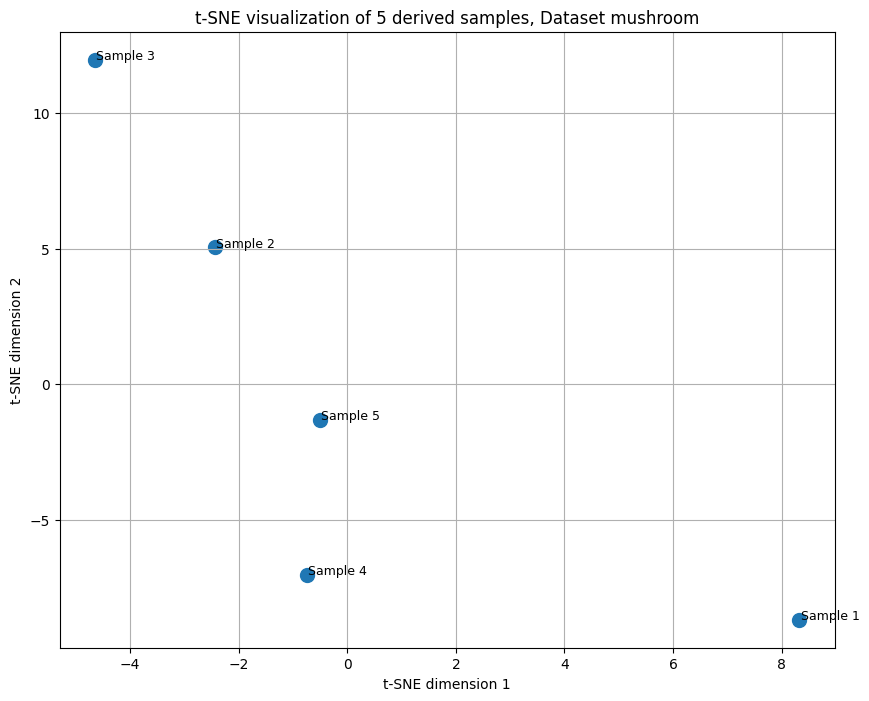

In [13]:
import numpy as np
last = np.load("last.npy")


tsne_model = TSNE(
    n_components=2,       # For 2D visualization
    perplexity=1.33,
    random_state=42,      # For reproducibility
    metric="euclidean",   # Default metric
    n_jobs=-1             # Use all available CPU cores
)
embedding = tsne_model.fit(last)
plt.figure(figsize=(10, 8))

if embedding is not None:
    plt.scatter(embedding[:, 0], embedding[:, 1], s=100) # s is marker size
    # You can add labels if these 5 "samples" have distinct meanings
    for i in range(embedding.shape[0]):
        plt.text(embedding[i, 0] + 0.02, embedding[i, 1] + 0.02, f"Sample {i+1}", fontsize=9)
title = f't-SNE visualization of Last 5 derived samples, Dataset mushroom'
plt.title(title)
plt.xlabel('t-SNE dimension 1')
plt.ylabel('t-SNE dimension 2')
plt.grid(True)
plt.show()

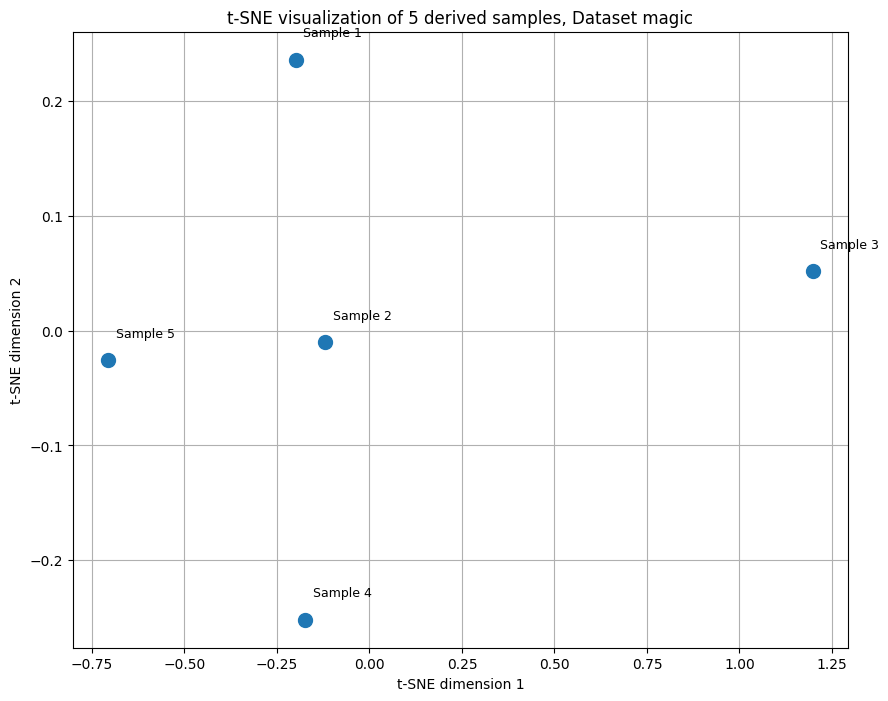

In [2]:
import numpy as np
first = np.load("magic_first.npy")


tsne_model = TSNE(
    n_components=2,       # For 2D visualization
    perplexity=1.33,
    random_state=42,      # For reproducibility
    metric="euclidean",   # Default metric
    n_jobs=-1             # Use all available CPU cores
)
embedding = tsne_model.fit(first)
plt.figure(figsize=(10, 8))

if embedding is not None:
    plt.scatter(embedding[:, 0], embedding[:, 1], s=100) # s is marker size
    # You can add labels if these 5 "samples" have distinct meanings
    for i in range(embedding.shape[0]):
        plt.text(embedding[i, 0] + 0.02, embedding[i, 1] + 0.02, f"Sample {i+1}", fontsize=9)
title = f't-SNE visualization of 5 derived samples, Dataset magic'
plt.title(title)
plt.xlabel('t-SNE dimension 1')
plt.ylabel('t-SNE dimension 2')
plt.grid(True)
plt.show()

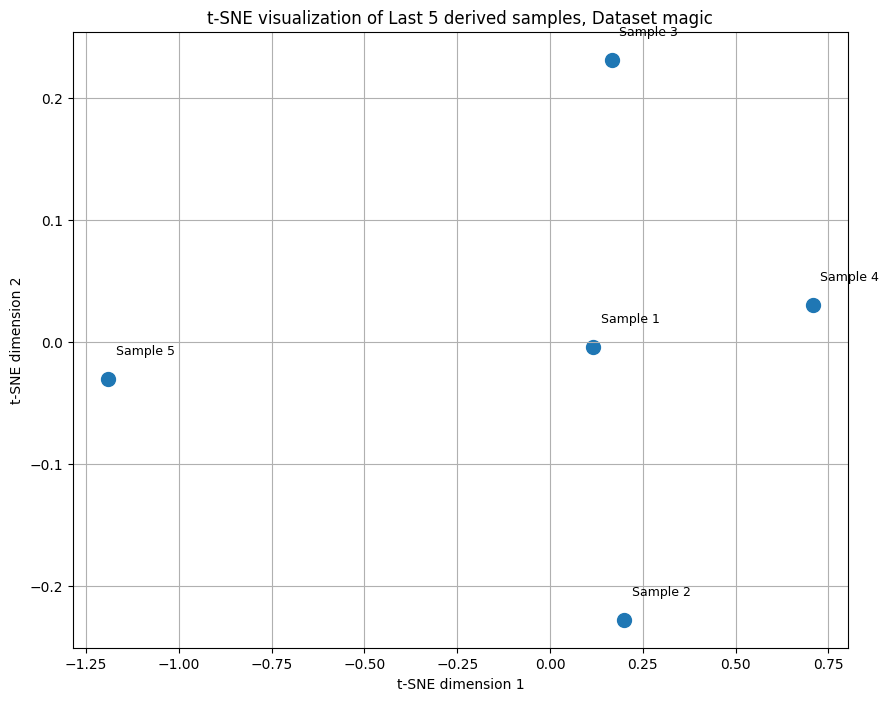

In [3]:
import numpy as np
last = np.load("magic_last.npy")


tsne_model = TSNE(
    n_components=2,       # For 2D visualization
    perplexity=1.33,
    random_state=42,      # For reproducibility
    metric="euclidean",   # Default metric
    n_jobs=-1             # Use all available CPU cores
)
embedding = tsne_model.fit(last)
plt.figure(figsize=(10, 8))

if embedding is not None:
    plt.scatter(embedding[:, 0], embedding[:, 1], s=100) # s is marker size
    # You can add labels if these 5 "samples" have distinct meanings
    for i in range(embedding.shape[0]):
        plt.text(embedding[i, 0] + 0.02, embedding[i, 1] + 0.02, f"Sample {i+1}", fontsize=9)
title = f't-SNE visualization of Last 5 derived samples, Dataset magic'
plt.title(title)
plt.xlabel('t-SNE dimension 1')
plt.ylabel('t-SNE dimension 2')
plt.grid(True)
plt.show()